In [19]:
# Import required libraries and dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
import tensorflow as tf
from pathlib import Path

In [20]:
# Specify the path to your CSV file
file_path = Path("Resources/Cars.xlsx")

# Read the CSV file into a DataFrame
table_df = pd.read_excel(file_path)

# Fix the year
table_df['Year'] = table_df['Year'].fillna(0).astype(int)
table_df.tail(5)

,Month,Year,Not seasonally adjusted (Thousands),"Combined seasonal, trading-day factor",Seasonally adjusted (Thousands),Seasonally adjusted at annual rates (Millions)
676,May,2023,205.765,105.85,194.393009,2.332716
677,June,2023,206.552,106.45,194.036637,2.328440
678,July,2023,191.771,97.20,197.295267,2.367543
679,August,2023,190.848,100.05,190.752624,2.289031
680,September,2023,196.482,101.45,193.673731,2.324085


In [21]:
# Group the data by year and sum the values
summarized_df = table_df.groupby('Year')['Seasonally adjusted  (Thousands)'].sum().reset_index()
print(summarized_df)

    Year  Seasonally adjusted  (Thousands)
0   1967                       7567.800000
1   1968                       8624.800000
2   1969                       8464.300000
3   1970                       7119.400000
4   1971                       8661.800000
5   1972                       9252.600000
6   1973                       9588.600000
7   1974                       7361.800000
8   1975                       6950.900000
9   1976                       8492.000000
10  1977                       8971.200000
11  1978                       9163.900000
12  1979                       8230.100000
13  1980                       6581.400000
14  1981                       6208.800000
15  1982                       5758.200000
16  1983                       6793.100000
17  1984                       7951.700000
18  1985                       8204.600000
19  1986                       8215.000000
20  1987                       7080.900000
21  1988                       7539.400000
22  1989   

In [22]:
# Time Series Splitting
train_size = int(0.8 * len(summarized_df))
train_data = summarized_df[:train_size]
test_data = summarized_df[train_size:]

In [23]:
# Data Scaling
scaler = MinMaxScaler(feature_range=(0, 10000))
# Apply scaling to the training data
train_data_copy = train_data.copy()
train_data_copy['Seasonally adjusted  (Thousands)'] = scaler.fit_transform(train_data_copy[['Seasonally adjusted  (Thousands)']])

# Apply the same scaling to the test data
test_data_copy = test_data.copy()
test_data_copy['Seasonally adjusted  (Thousands)'] = scaler.transform(test_data_copy[['Seasonally adjusted  (Thousands)']])

# Verify the loaded data
print("Loaded data shape:", summarized_df.shape)
print("Sample data:", summarized_df.head())

Loaded data shape: (57, 2)
Sample data:    Year  Seasonally adjusted  (Thousands)
0  1967                            7567.8
1  1968                            8624.8
2  1969                            8464.3
3  1970                            7119.4
4  1971                            8661.8


In [24]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []

    # Print data before the loop
    print("Data before loop:")
    print(data.head())

    for i in range(len(data) - sequence_length):
        sequence = data['Seasonally adjusted  (Thousands)'].values[i:i+sequence_length]
        target = data['Seasonally adjusted  (Thousands)'].values[i+sequence_length]
        sequences.append(sequence)
        targets.append(target)

        # Print the sliced sequence and target value inside the loop
        print("Sliced Sequence:")
        print(sequence)
        print("Target Value:")
        print(target)

    # Add print statements for debugging
    print("Sequence shape:", np.array(sequences).shape)
    print("Target shape:", np.array(targets).shape)

    return np.array(sequences), np.array(targets)


In [25]:
sequence_length = 5
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)



Data before loop:
   Year  Seasonally adjusted  (Thousands)
0  1967                            7567.8
1  1968                            8624.8
2  1969                            8464.3
3  1970                            7119.4
4  1971                            8661.8
Sliced Sequence:
[7567.8 8624.8 8464.3 7119.4 8661.8]
Target Value:
9252.6
Sliced Sequence:
[8624.8 8464.3 7119.4 8661.8 9252.6]
Target Value:
9588.6
Sliced Sequence:
[8464.3 7119.4 8661.8 9252.6 9588.6]
Target Value:
7361.8
Sliced Sequence:
[7119.4 8661.8 9252.6 9588.6 7361.8]
Target Value:
6950.9
Sliced Sequence:
[8661.8 9252.6 9588.6 7361.8 6950.9]
Target Value:
8492.0
Sliced Sequence:
[9252.6 9588.6 7361.8 6950.9 8492. ]
Target Value:
8971.2
Sliced Sequence:
[9588.6 7361.8 6950.9 8492.  8971.2]
Target Value:
9163.9
Sliced Sequence:
[7361.8 6950.9 8492.  8971.2 9163.9]
Target Value:
8230.1
Sliced Sequence:
[6950.9 8492.  8971.2 9163.9 8230.1]
Target Value:
6581.4
Sliced Sequence:
[8492.  8971.2 9163.9 8230.1 6581.4]
T

In [26]:
# Model Building
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [27]:
# Model Compilation
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [28]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (40, 5)
y_train shape: (40,)


In [29]:
print("X_train data:", X_train[:5])
print("y_train data:", y_train[:5])

X_train data: [[7567.8 8624.8 8464.3 7119.4 8661.8]
 [8624.8 8464.3 7119.4 8661.8 9252.6]
 [8464.3 7119.4 8661.8 9252.6 9588.6]
 [7119.4 8661.8 9252.6 9588.6 7361.8]
 [8661.8 9252.6 9588.6 7361.8 6950.9]]
y_train data: [9252.6 9588.6 7361.8 6950.9 8492. ]


In [30]:
# Model Training
model.fit(X_train, y_train, epochs=70, batch_size=32)

Epoch 1/70
2/2 [==============================] - 8s 12ms/step - loss: 47337748.0000 - mean_absolute_error: 6731.0703
Epoch 2/70
2/2 [==============================] - 0s 12ms/step - loss: 47336684.0000 - mean_absolute_error: 6730.9922
Epoch 3/70
2/2 [==============================] - 0s 21ms/step - loss: 47335624.0000 - mean_absolute_error: 6730.9126
Epoch 4/70
2/2 [==============================] - 0s 16ms/step - loss: 47334236.0000 - mean_absolute_error: 6730.8086
Epoch 5/70
2/2 [==============================] - 0s 17ms/step - loss: 47332616.0000 - mean_absolute_error: 6730.6890
Epoch 6/70
2/2 [==============================] - 0s 11ms/step - loss: 47330540.0000 - mean_absolute_error: 6730.5361
Epoch 7/70
2/2 [==============================] - 0s 13ms/step - loss: 47327944.0000 - mean_absolute_error: 6730.3398
Epoch 8/70
2/2 [==============================] - 0s 11ms/step - loss: 47323524.0000 - mean_absolute_error: 6730.0107
Epoch 9/70
2/2 [==============================] - 0s 11m

In [31]:
# Model Evaluation
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f"Training Loss: {train_loss}")
print(f"Testing Loss: {test_loss}")

1/1 [==============================] - 0s 36ms/step - loss: 9851159.0000 - mean_absolute_error: 2970.3633
Training Loss: [47121888.0, 6715.01708984375]
Testing Loss: [9851159.0, 2970.36328125]


In [32]:
# Prediction
y_pred = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [33]:
# Inverse transform the scaled predictions to get the actual values
y_pred_actual = scaler.inverse_transform(y_pred)

# Inverse transform the scaled test data to get the actual values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


In [34]:
for value in y_pred_actual:
    print(value)

[3568.0576]
[3568.0576]
[3568.0576]
[3568.0576]
[3568.0576]
[3568.0576]
[3568.0576]


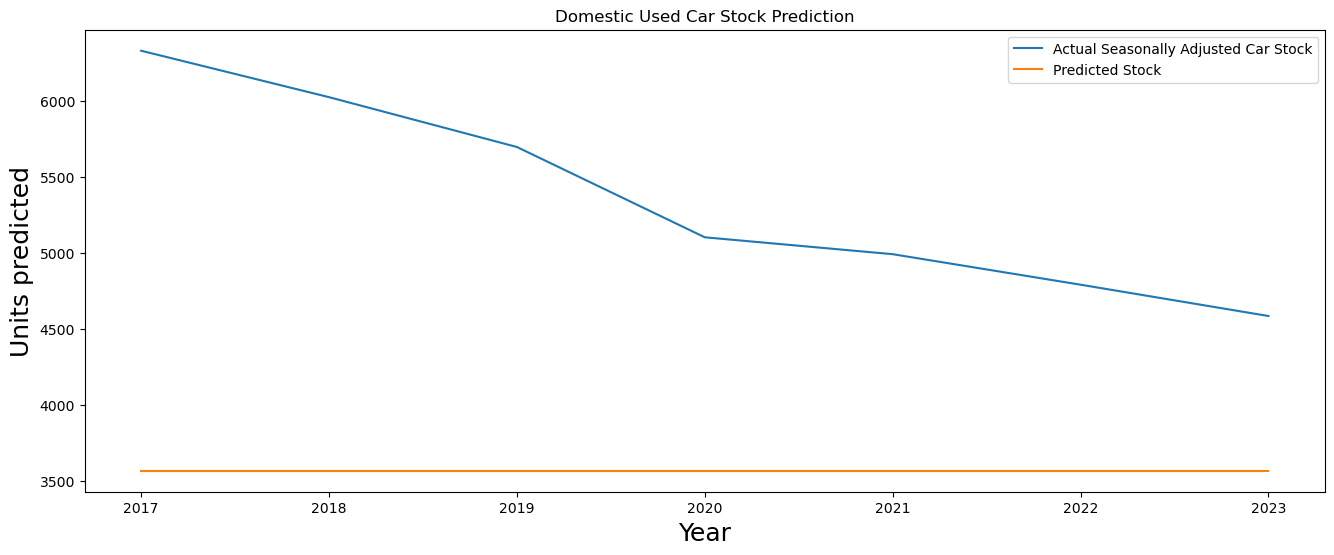

In [35]:
# Visualization
plt.figure(figsize=(16, 6))
plt.title('Domestic Used Car Stock Prediction')
plt.plot(test_data['Year'].iloc[sequence_length:], y_test_actual, label='Actual Seasonally Adjusted Car Stock')
plt.plot(test_data['Year'].iloc[sequence_length:], y_pred_actual, label='Predicted Stock')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Units predicted', fontsize=18)
plt.ticklabel_format(style='plain', axis='y')  # Format y-axis labels as plain numbers
plt.legend()
plt.show()


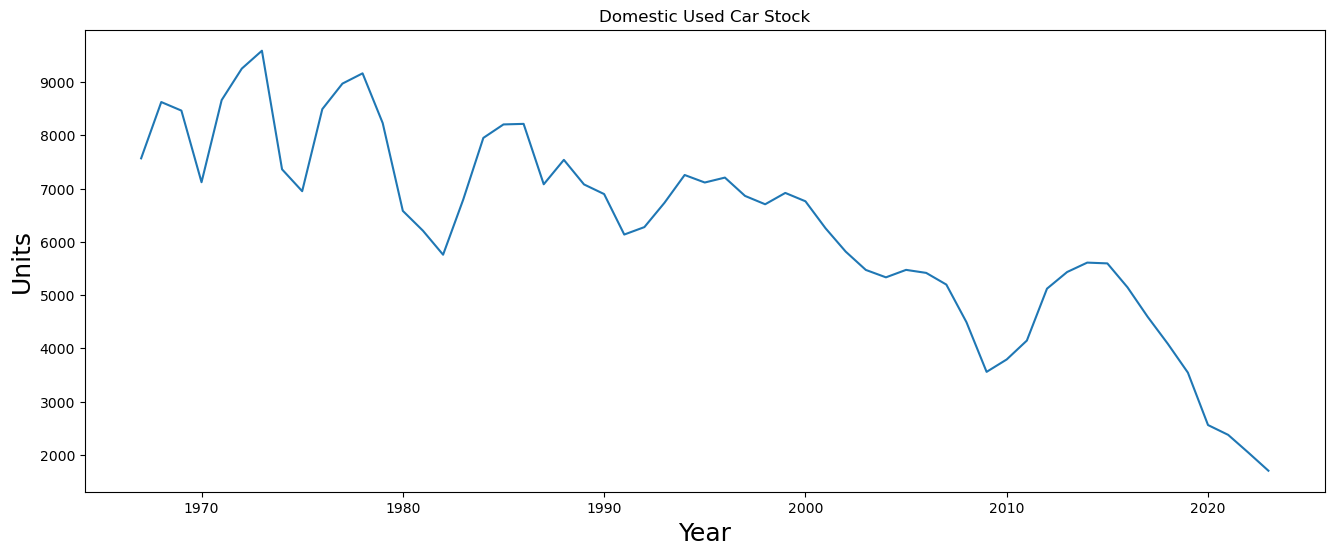

In [36]:
# Plotting the history (for the entire timeframe)
plt.figure(figsize=(16,6))
plt.title('Domestic Used Car Stock')
plt.plot(summarized_df['Year'], summarized_df['Seasonally adjusted  (Thousands)'])
plt.xlabel('Year', fontsize=18)
plt.ylabel('Units', fontsize=18)
plt.show()

